In [1]:
from utils import *

In [2]:
rng = PRNG(0)

In [3]:
theta = jnp.linspace(0, 2 * jnp.pi, 256)
radius = 2.0
depth = jnp.linspace(-2.0, 2.0, 256)

mu_i = jnp.stack((radius * jnp.sin(theta), radius * jnp.cos(theta), depth), axis=-1)
sigma_i = 1e-2 * jnp.ones_like(mu_i)

In [4]:
W = jnp.array([[1.0, 0.0, 2.0]])

def A(x):
    return jnp.einsum('...ij,...j', W, x)

sigma_y = 1e-2 ** 2 * jnp.eye(1)

y = jnp.array([0.0])

In [5]:
def prior(n):
    i = rng.randint((n,), minval=0, maxval=len(mu_i))

    x = mu_i[i]
    x = x + sigma_i[i] * rng.normal(x.shape)

    return x

def posterior(n):
    p_x = prior(n)
    log_p_y_x = jax.scipy.stats.multivariate_normal.logpdf(y, A(p_x), sigma_y)
    p_x_y = rng.choice(p_x, (n,), p=jnp.exp(log_p_y_x))

    return p_x_y

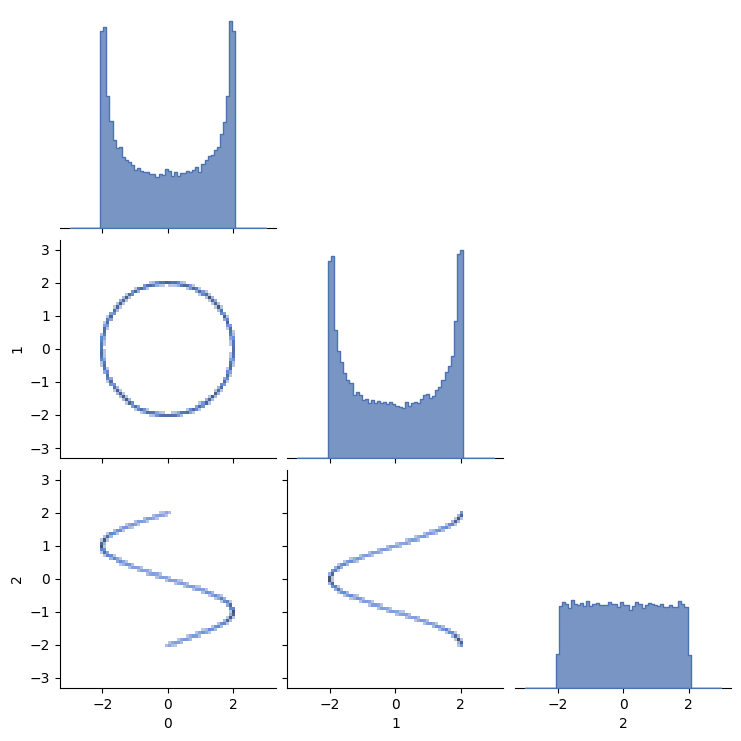

In [6]:
p_x = prior(65536)
sigma_x = jnp.cov(p_x.T)
fig = corner(p_x)

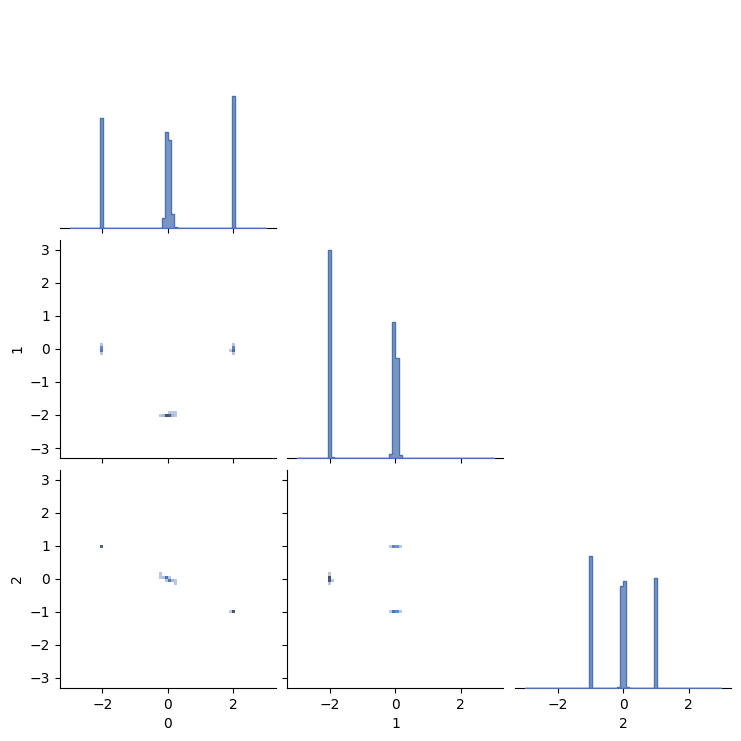

In [7]:
p_x_y = posterior(65536)
fig = corner(p_x_y)

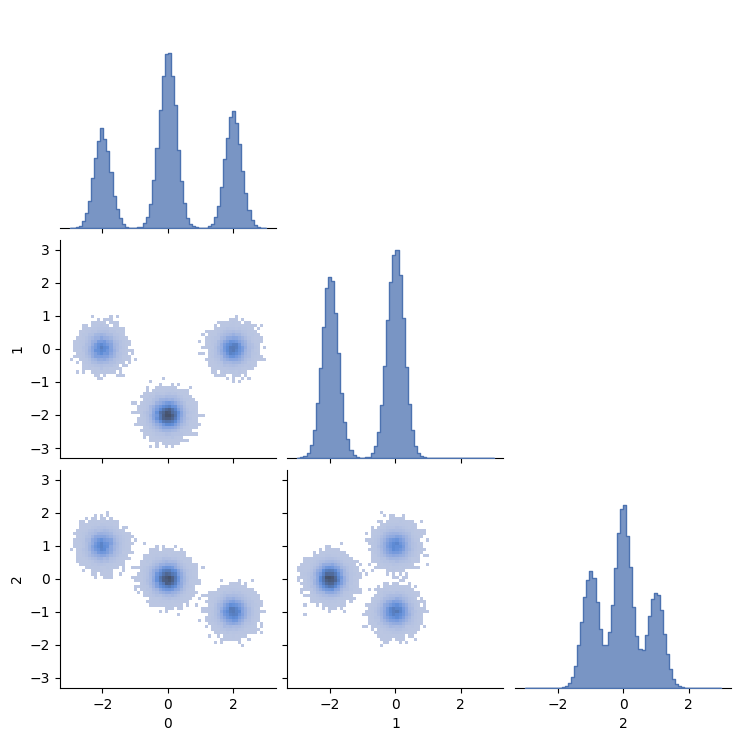

In [8]:
p_xt_y = p_x_y + 0.25 * rng.normal(p_x_y.shape)
fig = corner(p_xt_y)

In [9]:
def log_prior(xt, sigma_t):
    log_pi = jax.vmap(jax.scipy.stats.norm.logpdf, in_axes=(None, 0, 0))(xt, mu_i, jnp.sqrt(sigma_i**2 + sigma_t**2))
    log_pi = jnp.sum(log_pi, axis=-1)

    return jax.scipy.special.logsumexp(log_pi, axis=0)

def log_likelihood(xt, sigma_t, method):
        J = jnp.vectorize(jax.jacobian(log_prior), signature='(n),()->(n)')(xt, sigma_t)
        E_x_xt = xt + sigma_t**2 * J
        E_y_xt = A(E_x_xt)

        if method == 'zero':
            V_x_xt = 0.0 * jnp.eye(3)
        elif method == 'sigma_t':
            V_x_xt = sigma_t**2 * jnp.eye(3)
        else:
            if method == 'sigma_x':
                H = -jnp.linalg.inv(sigma_x + sigma_t**2 * jnp.eye(3))
            elif method == 'hessian':
                H = jnp.vectorize(jax.hessian(log_prior), signature='(n),()->(n,n)')(xt, sigma_t)

            V_x_xt = sigma_t**2 * jnp.eye(3) + sigma_t ** 4 * H

        V_y_xt = sigma_y + A(A(V_x_xt).mT)

        return jax.scipy.stats.multivariate_normal.logpdf(y, E_y_xt, V_y_xt)

def approx_posterior(n, sigma_t, method):
    p_x = prior(n)
    p_xt = p_x + sigma_t * rng.normal(p_x.shape)

    log_q_y_xt = log_likelihood(p_xt, sigma_t, method)

    q_xt_y = rng.choice(p_xt, (n,), p=jnp.exp(log_q_y_xt))

    return q_xt_y

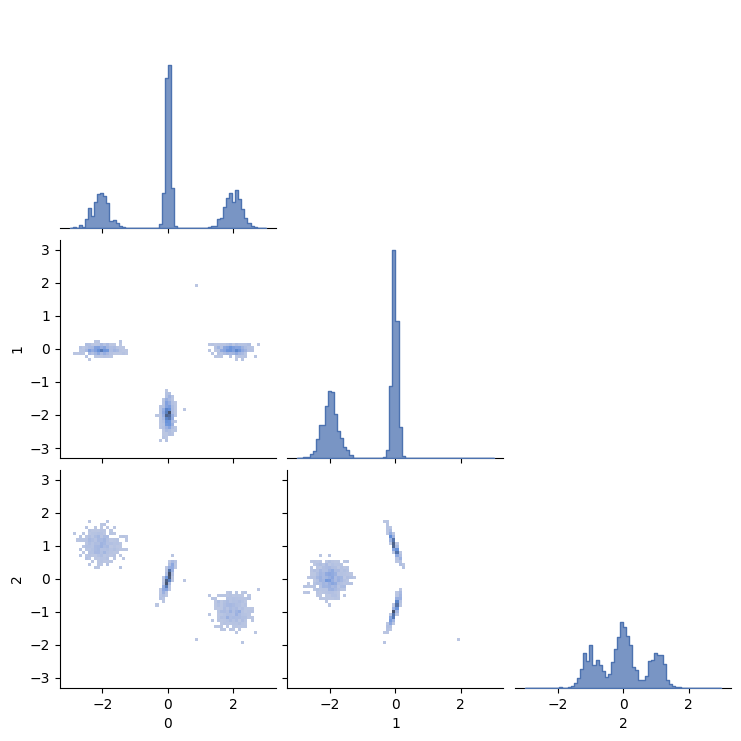

In [10]:
q_xt_y = approx_posterior(65536, sigma_t=0.25, method='zero')
fig = corner(q_xt_y)

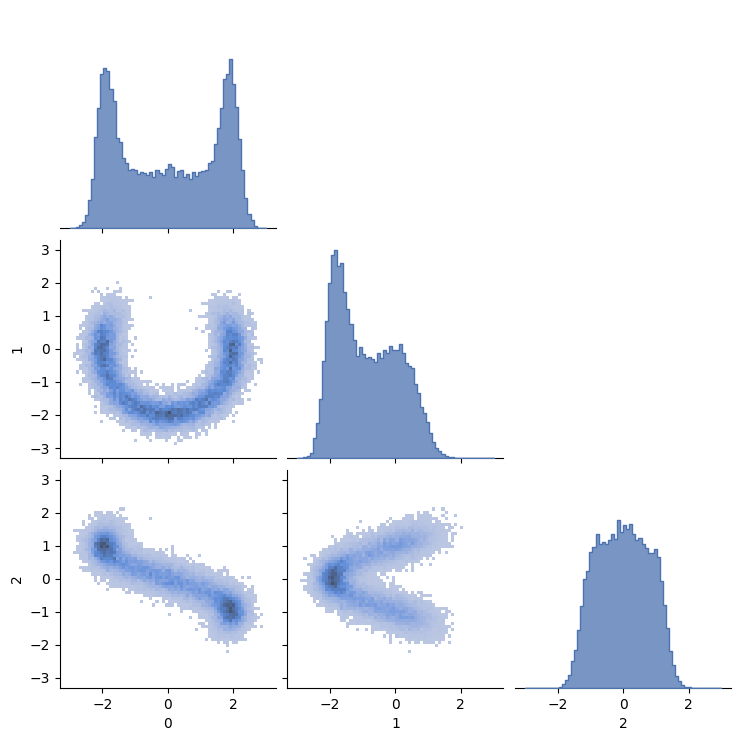

In [11]:
q_xt_y = approx_posterior(65536, sigma_t=0.25, method='sigma_t')
fig = corner(q_xt_y)

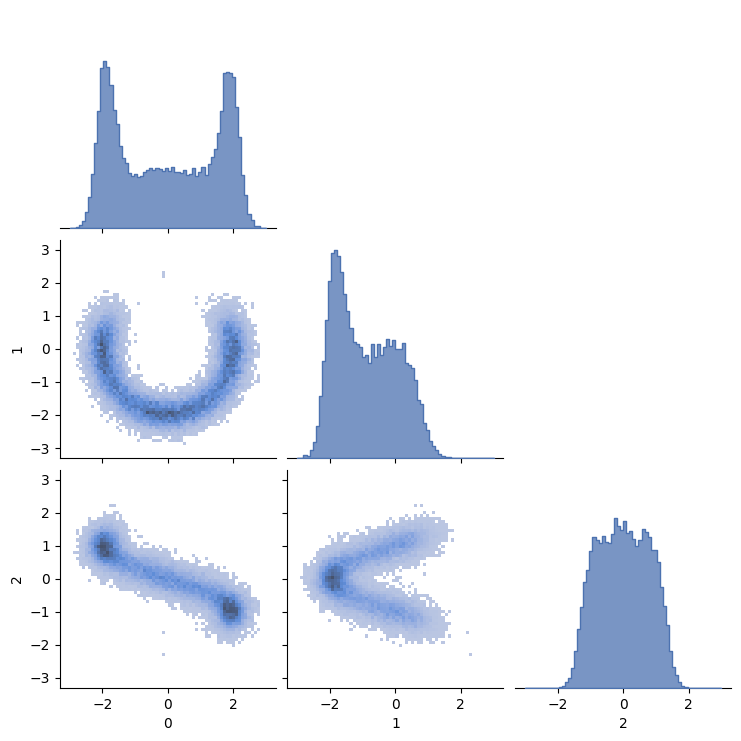

In [12]:
q_xt_y = approx_posterior(65536, sigma_t=0.25, method='sigma_x')
fig = corner(q_xt_y)

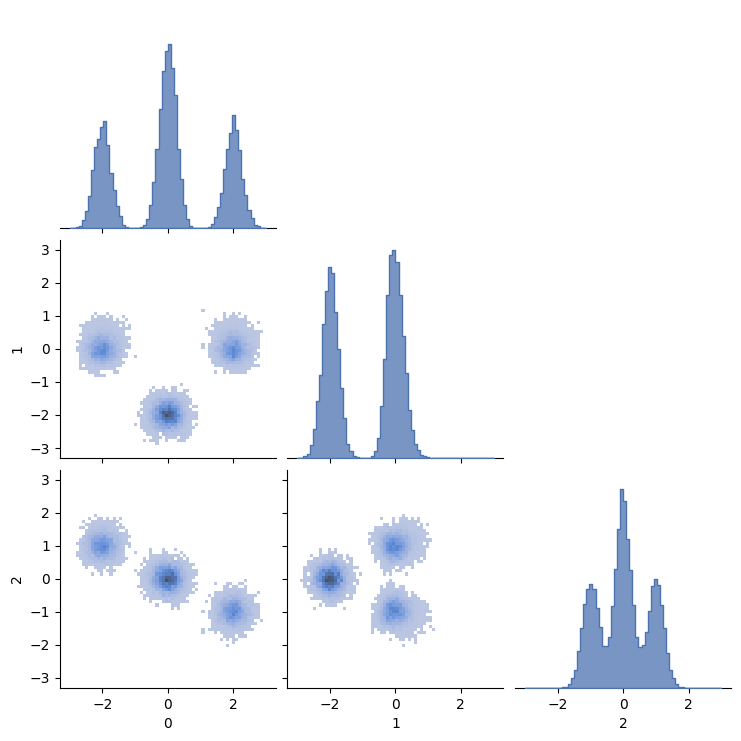

In [13]:
q_xt_y = approx_posterior(65536, sigma_t=0.25, method='hessian')
fig = corner(q_xt_y)